In [1]:
#Libraries and packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from itertools import product
import math
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
# Warnings -------------------------------------------------
import warnings
warnings.filterwarnings('once')
# warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

In [2]:
ss = pd.read_csv(r"C:\Users\chan_\OneDrive\Escritorio\Kaggle Competitions\Sticker sales Forecasting\sample_submission.csv")
test = pd.read_csv(r"C:\Users\chan_\OneDrive\Escritorio\Kaggle Competitions\Sticker sales Forecasting\test.csv")
train = pd.read_csv(r"C:\Users\chan_\OneDrive\Escritorio\Kaggle Competitions\Sticker sales Forecasting\train.csv")

In [3]:
##SOME EDA
train.shape
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


In [4]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [5]:
train_nulls = train[train['num_sold'].isnull()]

nulls_by_country = train_nulls['country'].value_counts()
nulls_by_product = train_nulls['product'].value_counts()
nulls_by_store = train_nulls['store'].value_counts()
nulls_by_country, nulls_by_product, nulls_by_store

(country
 Kenya     4625
 Canada    4246
 Name: count, dtype: int64,
 product
 Holographic Goose     8806
 Kerneler                64
 Kerneler Dark Mode       1
 Name: count, dtype: int64,
 store
 Discount Stickers       5179
 Stickers for Less       2666
 Premium Sticker Mart    1026
 Name: count, dtype: int64)

In [6]:
#Dataframe for the situation of each country, store and product to know the price trend of the stickers										
#to be able to replace the nulls with values that accompany these trends										
ken_sfl_hg = train.loc[(train['country'] == 'Kenya') & (train['store'] == 'Stickers for Less') & (train['product'] == 'Holographic Goose')]										
ken_sfl_ker = train.loc[(train['country'] == 'Kenya') & (train['store'] == 'Stickers for Less') & (train['product'] == 'Kerneler')]										
ken_sfl_kdm = train.loc[(train['country'] == 'Kenya') & (train['store'] == 'Stickers for Less') & (train['product'] == 'Kerneler Dark Mode')]										
ken_ds_hg = train.loc[(train['country'] == 'Kenya') & (train['store'] == 'Discount Stickers') & (train['product'] == 'Holographic Goose')]										
ken_ds_ker = train.loc[(train['country'] == 'Kenya') & (train['store'] == 'Discount Stickers') & (train['product'] == 'Kerneler')]										
ken_ds_kdm = train.loc[(train['country'] == 'Kenya') & (train['store'] == 'Discount Stickers') & (train['product'] == 'Kerneler Dark Mode')]										
ken_psm_hg = train.loc[(train['country'] == 'Kenya') & (train['store'] == 'Premium Sticker Mart') & (train['product'] == 'Holographic Goose')]										
ken_psm_ker = train.loc[(train['country'] == 'Kenya') & (train['store'] == 'Premium Sticker Mart') & (train['product'] == 'Kerneler')]										
ken_psm_kdm = train.loc[(train['country'] == 'Kenya') & (train['store'] == 'Premium Sticker Mart') & (train['product'] == 'Kerneler Dark Mode')]										
										
										
can_sfl_hg = train.loc[(train['country'] == 'Canada') & (train['store'] == 'Stickers for Less') & (train['product'] == 'Holographic Goose')]										
can_sfl_ker = train.loc[(train['country'] == 'Canada') & (train['store'] == 'Stickers for Less') & (train['product'] == 'Kerneler')]										
can_sfl_kdm = train.loc[(train['country'] == 'Canada') & (train['store'] == 'Stickers for Less') & (train['product'] == 'Kerneler Dark Mode')]										
can_ds_hg = train.loc[(train['country'] == 'Canada') & (train['store'] == 'Discount Stickers') & (train['product'] == 'Holographic Goose')]										
can_ds_ker = train.loc[(train['country'] == 'Canada') & (train['store'] == 'Discount Stickers') & (train['product'] == 'Kerneler')]										
can_ds_kdm = train.loc[(train['country'] == 'Canada') & (train['store'] == 'Discount Stickers') & (train['product'] == 'Kerneler Dark Mode')]										
can_psm_hg = train.loc[(train['country'] == 'Canada') & (train['store'] == 'Premium Sticker Mart') & (train['product'] == 'Holographic Goose')]										
can_psm_ker = train.loc[(train['country'] == 'Canada') & (train['store'] == 'Premium Sticker Mart') & (train['product'] == 'Kerneler')]										
can_psm_kdm = train.loc[(train['country'] == 'Canada') & (train['store'] == 'Premium Sticker Mart') & (train['product'] == 'Kerneler Dark Mode')]							

In [7]:
# Creating a dict with the new df.									
dataframes = {										
'ken_sfl_hg': ken_sfl_hg,										
'ken_sfl_ker': ken_sfl_ker,										
'ken_sfl_kdm': ken_sfl_kdm,										
'ken_ds_hg': ken_ds_hg,										
'ken_ds_ker': ken_ds_ker,										
'ken_ds_kdm': ken_ds_kdm,										
'ken_psm_hg': ken_psm_hg,										
'ken_psm_ker': ken_psm_ker,										
'ken_psm_kdm': ken_psm_kdm,										
'can_sfl_hg': can_sfl_hg,										
'can_sfl_ker': can_sfl_ker,										
'can_sfl_kdm': can_sfl_kdm,										
'can_ds_hg': can_ds_hg,										
'can_ds_ker': can_ds_ker,										
'can_ds_kdm': can_ds_kdm,										
'can_psm_hg': can_psm_hg,										
'can_psm_ker': can_psm_ker,										
'can_psm_kdm': can_psm_kdm										
}										
										
# Iterate over dictionary to count nulls								
null_counts = {}
for name, df in dataframes.items():
    null_count = df.isna().sum().sum()  # Suma de todos los valores nulos en el DataFrame
    null_counts[name] = null_count
    print(f"{name}: {null_count} valores nulos")

ken_sfl_hg: 1358 valores nulos
ken_sfl_ker: 0 valores nulos
ken_sfl_kdm: 0 valores nulos
ken_ds_hg: 2557 valores nulos
ken_ds_ker: 63 valores nulos
ken_ds_kdm: 1 valores nulos
ken_psm_hg: 646 valores nulos
ken_psm_ker: 0 valores nulos
ken_psm_kdm: 0 valores nulos
can_sfl_hg: 1308 valores nulos
can_sfl_ker: 0 valores nulos
can_sfl_kdm: 0 valores nulos
can_ds_hg: 2557 valores nulos
can_ds_ker: 1 valores nulos
can_ds_kdm: 0 valores nulos
can_psm_hg: 380 valores nulos
can_psm_ker: 0 valores nulos
can_psm_kdm: 0 valores nulos


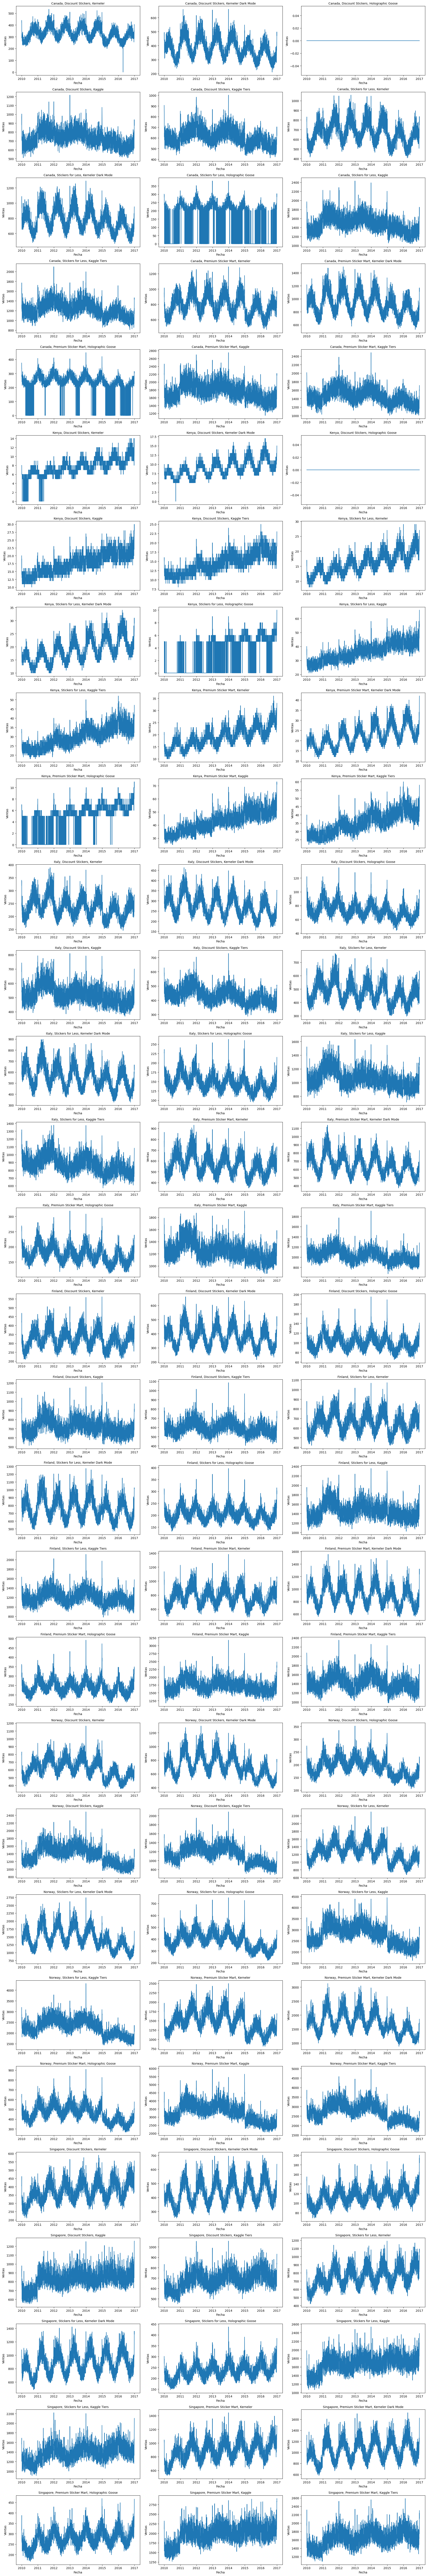

In [8]:
# I'll display a graph for each df
#Lists
countries = ['Canada', 'Kenya', 'Italy', 'Finland', 'Norway', 'Singapore']
stores = ['Discount Stickers', 'Stickers for Less', 'Premium Sticker Mart']
products = ['Kerneler', 'Kerneler Dark Mode', 'Holographic Goose', 'Kaggle', 'Kaggle Tiers']

# Total number of convinations
total_combinations = len(countries) * len(stores) * len(products)

# size of the grid (rows and columns)
cols = 3  # Columns per row
rows = math.ceil(total_combinations / cols)  # Number of necesary rows

# Plots and subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))  # Ajusta el tamaño según lo necesites
axes = axes.flatten()  # Aplanar los ejes para iterar fácilmente

index = 0
for country, store, product_name in product(countries, stores, products):
    # Filtrar el DataFrame para la combinación actual
    filtered_df = train[
        (train['country'] == country) &
        (train['store'] == store) &
        (train['product'] == product_name)
    ]
    
    # Check if the filtered DataFrame is not empty
    if not filtered_df.empty:
        # Agrupar por fecha y sumar las ventas
        sales_by_date = filtered_df.groupby('date')['num_sold'].sum()
        
        # Crear subgráfico
        axes[index].plot(sales_by_date.index, sales_by_date.values)
        axes[index].set_title(f"{country}, {store}, {product_name}", fontsize=10)
        axes[index].set_xlabel("Fecha")
        axes[index].set_ylabel("Ventas")
    else:
        axes[index].set_visible(False)  
    
    index += 1

# Delete remaining empty subgraphs
for i in range(index, len(axes)):
    axes[i].set_visible(False)

# Spsces between graphics
plt.tight_layout()
plt.show()

In [9]:
# New dict with df where there are nulls									
dataframes_with_nulls = {										
'ken_sfl_hg': ken_sfl_hg,										
'ken_ds_hg': ken_ds_hg,										
'ken_ds_ker': ken_ds_ker,										
'ken_ds_kdm': ken_ds_kdm,										
'ken_psm_hg': ken_psm_hg,										
'can_sfl_hg': can_sfl_hg,										
'can_sfl_ker': can_sfl_ker,										
'can_ds_hg': can_ds_hg,										
'can_ds_ker': can_ds_ker,										
'can_psm_hg': can_psm_hg,										
}							

In [10]:
#Length of each df
dict_shape = {}
for name, df in dataframes_with_nulls.items():
    shape = df.shape[0]  # Forma del DataFrame (filas, columnas)
    dict_shape[name] = shape
print(dict_shape)

{'ken_sfl_hg': 2557, 'ken_ds_hg': 2557, 'ken_ds_ker': 2557, 'ken_ds_kdm': 2557, 'ken_psm_hg': 2557, 'can_sfl_hg': 2557, 'can_sfl_ker': 2557, 'can_ds_hg': 2557, 'can_ds_ker': 2557, 'can_psm_hg': 2557}


In [11]:
#Cases were the nulls represent a really small percentage could be replaced with the median.
ken_ds_ker['num_sold'] = ken_ds_ker['num_sold'].fillna(ken_ds_ker['num_sold'].median())
ken_ds_kdm['num_sold'] = ken_ds_kdm['num_sold'].fillna(ken_ds_kdm['num_sold'].median())
can_ds_ker['num_sold'] = can_ds_ker['num_sold'].fillna(can_ds_ker['num_sold'].median())
print('Ken_ds_ker have',ken_ds_ker['num_sold'].isnull().sum(),'nulls')
print('Ken_ds_kdm have',ken_ds_kdm['num_sold'].isnull().sum(),'nulls')
print('Can_ds_ker have',can_ds_ker['num_sold'].isnull().sum(),'nulls')

Ken_ds_ker have 0 nulls
Ken_ds_kdm have 0 nulls
Can_ds_ker have 0 nulls


C:\Users\chan_\AppData\Local\Temp\ipykernel_11568\2855258343.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ken_ds_ker['num_sold'] = ken_ds_ker['num_sold'].fillna(ken_ds_ker['num_sold'].median())
C:\Users\chan_\AppData\Local\Temp\ipykernel_11568\2855258343.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ken_ds_kdm['num_sold'] = ken_ds_kdm['num_sold'].fillna(ken_ds_kdm['num_sold'].median())
C:\Users\chan_\AppData\Local\Temp\ipykernel_11568\2855258343.py:4: SettingWithCopyWarning: 
A value is trying 

In [12]:
# For ken_ds_hg
ken_ds_hg['num_sold'] = train[
    (train['country'] == 'Kenya') & 
    (train['store'] == 'Discount Stickers')
]['num_sold'].median()

# For can_ds_hg
can_ds_hg['num_sold'] = train[
    (train['store'] == 'Discount Stickers') & 
    (train['product'] == 'Holographic Goose')
]['num_sold'].median()

print("ken_ds_hg:")
print(ken_ds_hg['num_sold'].head())

print("can_ds_hg:")
print(can_ds_hg['num_sold'].head())
                                                                                       

ken_ds_hg:
45     11.0
135    11.0
225    11.0
315    11.0
405    11.0
Name: num_sold, dtype: float64
can_ds_hg:
0      104.0
90     104.0
180    104.0
270    104.0
360    104.0
Name: num_sold, dtype: float64


C:\Users\chan_\AppData\Local\Temp\ipykernel_11568\1722587241.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ken_ds_hg['num_sold'] = train[
C:\Users\chan_\AppData\Local\Temp\ipykernel_11568\1722587241.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  can_ds_hg['num_sold'] = train[


Text(0, 0.5, 'Sales')

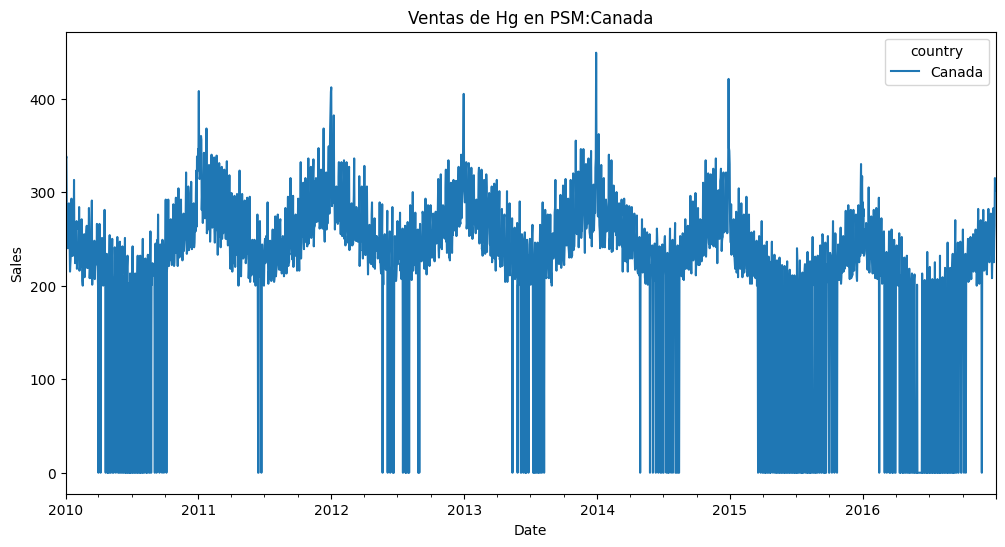

In [13]:
can_psm_hg_plot = can_psm_hg.groupby(['date', 'country'])['num_sold'].sum().unstack()

can_psm_hg_plot.plot(figsize=(12,6), title ='Ventas de Hg en PSM:Canada')
plt.xlabel('Date')
plt.ylabel('Sales')


In [14]:
# --------------------------------------------------------------------------------
# Random Forest to replace nulls in "num_sold" for the can_psm_hg dataset
# --------------------------------------------------------------------------------

import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# 1. Convertir la columna 'date' a formato datetime y extraer features temporales
can_psm_hg['date'] = pd.to_datetime(can_psm_hg['date'])
can_psm_hg['year'] = can_psm_hg['date'].dt.year
can_psm_hg['month'] = can_psm_hg['date'].dt.month
can_psm_hg['day_of_week'] = can_psm_hg['date'].dt.dayofweek
can_psm_hg['day_of_year'] = can_psm_hg['date'].dt.dayofyear
can_psm_hg['is_weekend'] = (can_psm_hg['day_of_week'] >= 5).astype(int)

# 2. Dividir el dataset en entrenamiento y predicción (en base a valores nulos en 'num_sold')
train_data = can_psm_hg[can_psm_hg['num_sold'].notna()]
predict_data = can_psm_hg[can_psm_hg['num_sold'].isna()]

# 3. Definir las características (features) y la variable objetivo (target)
features = ['year', 'month', 'day_of_week', 'day_of_year', 'is_weekend']
X_train = train_data[features]
y_train = train_data['num_sold']
X_predict = predict_data[features]

# 4. Evaluación del modelo mediante Cross-Validation
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
cv_scores_rf = cross_val_score(
    rf_model, 
    X_train, 
    y_train, 
    cv=5, 
    scoring='neg_mean_absolute_error'
)

# 5. Calcular la métrica MAE (Mean Absolute Error) a partir de los resultados de CV
results = {
    "Random Forest MAE (CV)": -np.mean(cv_scores_rf)
}
print("Resultados de Cross-Validation:", results)

# 6. Entrenar el modelo final con todo el conjunto de entrenamiento
rf_model.fit(X_train, y_train)

# 7. Predecir los valores faltantes para 'num_sold'
rf_predictions = rf_model.predict(X_predict)

# 8. Imputar los valores nulos en 'num_sold' con las predicciones
can_psm_hg.loc[can_psm_hg['num_sold'].isna(), 'num_sold'] = rf_predictions


C:\Users\chan_\AppData\Local\Temp\ipykernel_11568\3980774637.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  can_psm_hg['date'] = pd.to_datetime(can_psm_hg['date'])
C:\Users\chan_\AppData\Local\Temp\ipykernel_11568\3980774637.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  can_psm_hg['year'] = can_psm_hg['date'].dt.year
C:\Users\chan_\AppData\Local\Temp\ipykernel_11568\3980774637.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

Resultados de Cross-Validation: {'Random Forest MAE (CV)': 17.955761942423283}


C:\Users\chan_\AppData\Local\Temp\ipykernel_11568\906169782.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  can_psm_hg['date'] = can_psm_hg['date'].dt.strftime('%Y-%m-%d')


Text(0, 0.5, 'Sales')

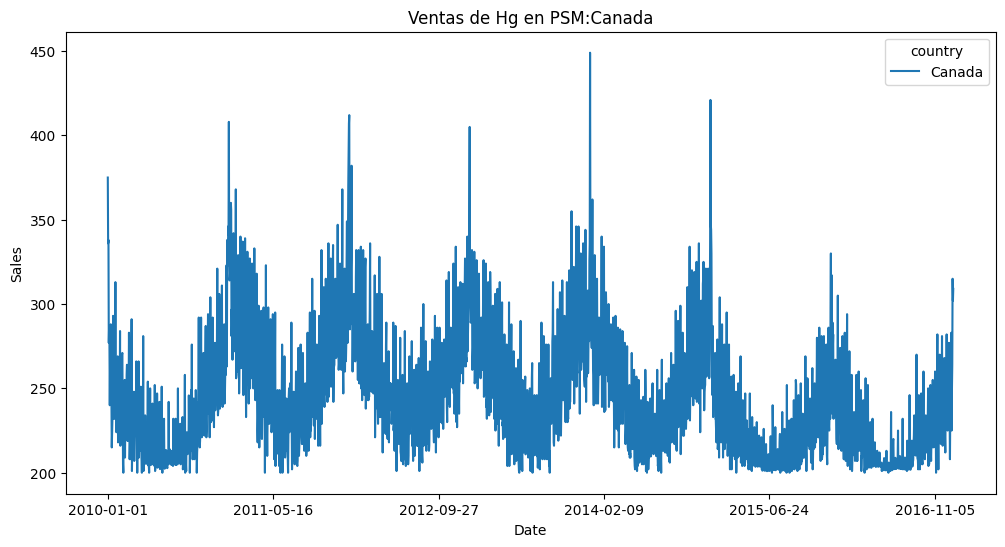

In [15]:
# Restore date column
can_psm_hg['date'] = can_psm_hg['date'].dt.strftime('%Y-%m-%d')
# Group by date and country
can_psm_hg_plot2 = can_psm_hg.groupby(['date', 'country'])['num_sold'].sum().unstack()

can_psm_hg_plot2.plot(figsize=(12,6), title ='Ventas de Hg en PSM:Canada')
plt.xlabel('Date')
plt.ylabel('Sales')

Text(0, 0.5, 'Sales')

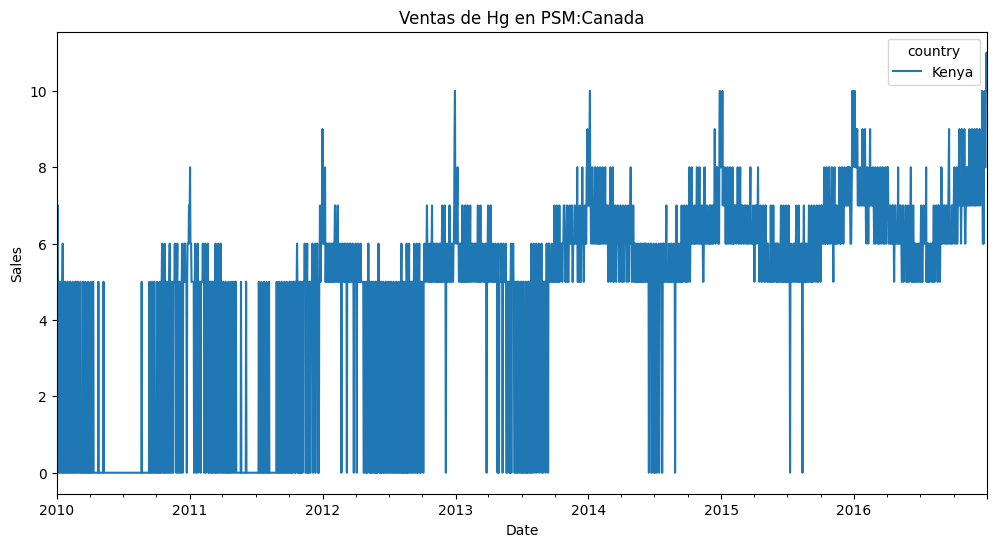

In [16]:
ken_psm_hg_plot = ken_psm_hg.groupby(['date', 'country'])['num_sold'].sum().unstack()

ken_psm_hg_plot.plot(figsize=(12,6), title ='Ventas de Hg en PSM:Canada')
plt.xlabel('Date')
plt.ylabel('Sales')

C:\Users\chan_\AppData\Local\Temp\ipykernel_11568\1446379494.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ken_psm_hg['date'] = pd.to_datetime(ken_psm_hg['date'])
C:\Users\chan_\AppData\Local\Temp\ipykernel_11568\1446379494.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ken_psm_hg['year'] = ken_psm_hg['date'].dt.year
C:\Users\chan_\AppData\Local\Temp\ipykernel_11568\1446379494.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

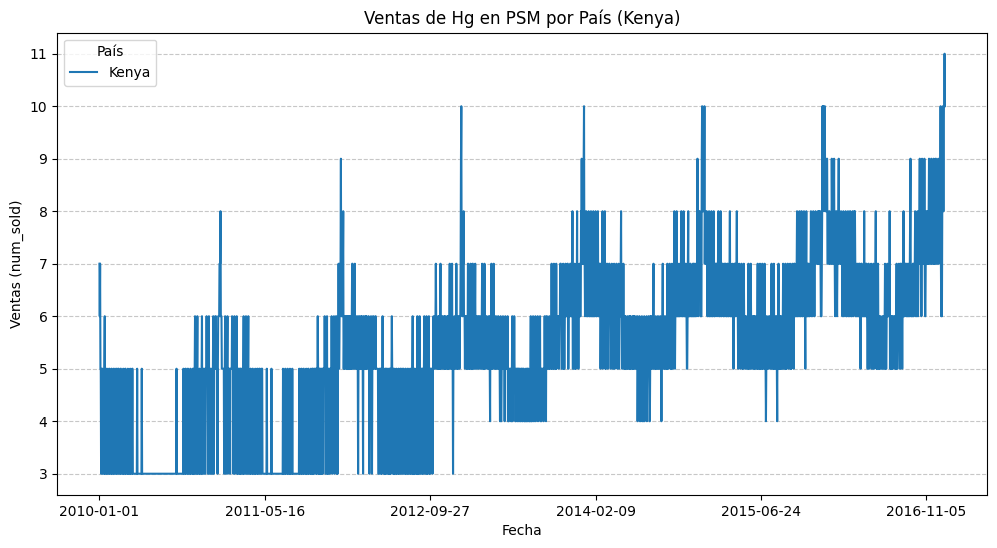

In [17]:
###random forest for ken_psm_hg but 
##the predictive model simply changed the nulls to the value 5 seeing this
#I understand that replacing the nulls with the value of 4 or 3 sales would be more representative of the missing data

ken_psm_hg['date'] = pd.to_datetime(ken_psm_hg['date'])
ken_psm_hg['year'] = ken_psm_hg['date'].dt.year

# Replace null values ​​in 'num_sold' based on temporal thirds
ken_psm_hg.loc[(ken_psm_hg['num_sold'].isna()) & (ken_psm_hg['year'] <= 2012), 'num_sold'] = 3
ken_psm_hg.loc[(ken_psm_hg['num_sold'].isna()) & (ken_psm_hg['year'] > 2012), 'num_sold'] = 4


ken_psm_hg['date'] = ken_psm_hg['date'].dt.strftime('%Y-%m-%d')


ken_psm_hg_plot2 = ken_psm_hg.groupby(['date', 'country'])['num_sold'].sum().unstack()

# Graph

ken_psm_hg_plot2.plot(figsize=(12, 6), title='Ventas de Hg en PSM por País (Kenya)')
plt.xlabel('Fecha')
plt.ylabel('Ventas (num_sold)')
plt.legend(title='País', loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [18]:
# Convert 'date' column to datetime format and extract temporal features
can_sfl_hg['date'] = pd.to_datetime(can_sfl_hg['date'], errors='coerce')
can_sfl_hg['year'] = can_sfl_hg['date'].dt.year
can_sfl_hg['month'] = can_sfl_hg['date'].dt.month
can_sfl_hg['day_of_week'] = can_sfl_hg['date'].dt.dayofweek
can_sfl_hg['day_of_year'] = can_sfl_hg['date'].dt.dayofyear
can_sfl_hg['is_weekend'] = (can_sfl_hg['day_of_week'] >= 5).astype(int)

# Dividing dataset in train and test data
train_data = can_sfl_hg[can_sfl_hg['num_sold'].notna()]
predict_data = can_sfl_hg[can_sfl_hg['num_sold'].isna()].copy()  # Usar .copy() para evitar advertencias

features = ['year', 'month', 'day_of_week', 'day_of_year', 'is_weekend']
X_train = train_data[features]
y_train = train_data['num_sold']
X_predict = predict_data[features]

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_predict)

# cross-validation
cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

# Metrics calculation
results = {
    "Random Forest MAE (CV)": -np.mean(cv_scores_rf)
}

print("Resultados de Cross-Validation:", results)

# Impute null values in 'num_sold' using Random Forest
can_sfl_hg.loc[can_sfl_hg['num_sold'].isna(), 'num_sold'] = rf_predictions

C:\Users\chan_\AppData\Local\Temp\ipykernel_11568\3919701003.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  can_sfl_hg['date'] = pd.to_datetime(can_sfl_hg['date'], errors='coerce')
C:\Users\chan_\AppData\Local\Temp\ipykernel_11568\3919701003.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  can_sfl_hg['year'] = can_sfl_hg['date'].dt.year
C:\Users\chan_\AppData\Local\Temp\ipykernel_11568\3919701003.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Resultados de Cross-Validation: {'Random Forest MAE (CV)': 14.802917654618474}


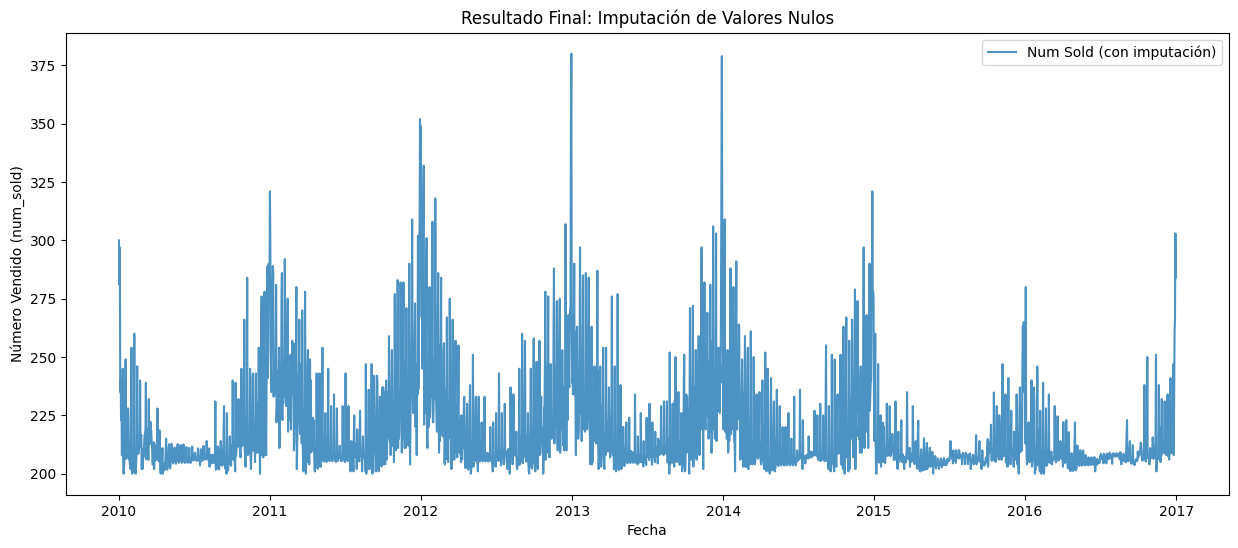

In [19]:
# Graph after the imputation
plt.figure(figsize=(15, 6))
plt.plot(can_sfl_hg['date'], can_sfl_hg['num_sold'], label='Num Sold (con imputación)', alpha=0.8)

plt.title('Resultado Final: Imputación de Valores Nulos')
plt.xlabel('Fecha')
plt.ylabel('Número Vendido (num_sold)')
plt.legend()
plt.show()

C:\Users\chan_\AppData\Local\Temp\ipykernel_11568\2342110399.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ken_sfl_hg['date'] = pd.to_datetime(ken_sfl_hg['date'])
C:\Users\chan_\AppData\Local\Temp\ipykernel_11568\2342110399.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ken_sfl_hg['year'] = ken_sfl_hg['date'].dt.year
C:\Users\chan_\AppData\Local\Temp\ipykernel_11568\2342110399.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

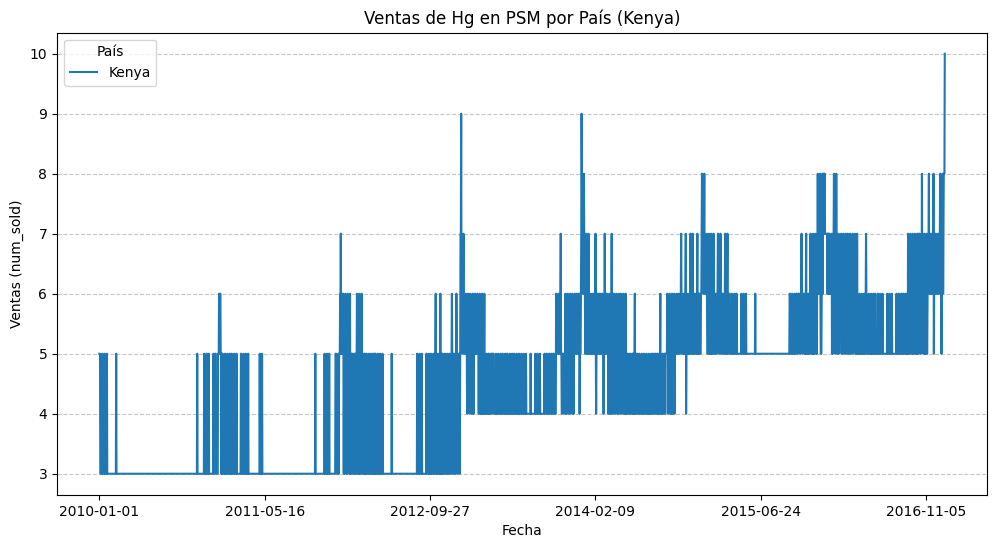

In [20]:
##the predictive model simply changed the nulls to the value 5 seeing this
#I understand that replacing nulls with values ​​3, 4 or 5 would be more representative of the missing data
# Convert 'date' column to datetime format
ken_sfl_hg['date'] = pd.to_datetime(ken_sfl_hg['date'])

ken_sfl_hg['year'] = ken_sfl_hg['date'].dt.year

ken_sfl_hg.loc[(ken_sfl_hg['num_sold'].isna()) & (ken_sfl_hg['year'] <= 2012), 'num_sold'] = 3
ken_sfl_hg.loc[(ken_sfl_hg['num_sold'].isna()) & (ken_sfl_hg['year'] > 2012) & (ken_sfl_hg['year'] <= 2014), 'num_sold'] = 4
ken_sfl_hg.loc[(ken_sfl_hg['num_sold'].isna()) & (ken_sfl_hg['year'] > 2014), 'num_sold'] = 5


ken_sfl_hg['date'] = ken_sfl_hg['date'].dt.strftime('%Y-%m-%d')
ken_sfl_hg_plot = ken_sfl_hg.groupby(['date', 'country'])['num_sold'].sum().unstack()


ken_sfl_hg_plot.plot(figsize=(12, 6), title='Ventas de Hg en PSM por País (Kenya)')
plt.xlabel('Fecha')
plt.ylabel('Ventas (num_sold)')
plt.legend(title='País', loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [21]:
#Replace modified subsets into the original df
train.update(ken_sfl_hg)
train.update(ken_sfl_ker)
train.update(ken_sfl_kdm)
train.update(ken_ds_hg)
train.update(ken_ds_ker)
train.update(ken_ds_kdm)
train.update(ken_psm_hg)
train.update(ken_psm_ker)
train.update(ken_psm_kdm)

train.update(can_sfl_hg)
train.update(can_sfl_ker)
train.update(can_sfl_kdm)
train.update(can_ds_hg)
train.update(can_ds_ker)
train.update(can_ds_kdm)
train.update(can_psm_hg)
train.update(can_psm_ker)
train.update(can_psm_kdm)

In [22]:
#checking for nulls
train.isnull().sum()

id          0
date        0
country     0
store       0
product     0
num_sold    0
dtype: int64

In [23]:
##Finshing the project with the forecasting of the next three years sales
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

# Additional temporary features
for df in [train, test]:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek

# Categorical variables into dummies
train = pd.get_dummies(train, columns=['country', 'store', 'product'])
test = pd.get_dummies(test, columns=['country', 'store', 'product'])

# Ensure that test has the same columns as train
missing_cols = set(train.columns) - set(test.columns)
for col in missing_cols:
    test[col] = 0  # Agregar columnas faltantes con valor 0

test = test[train.columns.drop('num_sold')]  # Asegurar que las columnas coincidan

# Separate features and target variable
X = train.drop(columns=['id', 'date', 'num_sold'])
y = train['num_sold']
X_test = test.drop(columns=['id', 'date'])

# Split into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Training Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

#Evaluating the model in the valdation subset
y_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f'MAE en conjunto de validación: {mae:.2f}')

# Predicting values for test.csv
submission = test[['id']].copy()
submission['num_sold'] = model.predict(X_test)
submission['num_sold'] = submission['num_sold'].clip(lower=0)  # Evitar valores negativos

print(submission.info())


MAE en conjunto de validación: 37.73
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98550 entries, 0 to 98549
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        98550 non-null  int64  
 1   num_sold  98550 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 1.5 MB
None


In [27]:
submission['num_sold'] = np.ceil(submission['num_sold'])  # Round up

In [25]:
submission.to_csv("C:/Users/chan_/OneDrive/Escritorio/Kaggle Competitions/Sticker sales Forecasting/submission.csv", index=False)





In [26]:
# MAPE
mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100  
print(f'MAPE en conjunto de validación: {mape:.2f}%')


MAPE en conjunto de validación: 5.09%
